# XGBoost Regressor - Predicting Future Stock Price

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [3]:
# Read in stock historical prices and calculate daily return
stock_prices = pd.read_csv("../resources/stock_historical_prices.csv")
stock_prices = stock_prices.set_index("Date")
stock_prices["Return"] = stock_prices["Adj Close"].pct_change() * 100
stock_prices.dropna(inplace=True)
stock_prices.head()

FileNotFoundError: [Errno 2] No such file or directory: '../resources/stock_historical_prices.csv'

In [3]:
# Create a lagged return using the shift function
stock_prices["Lagged_Return"] = stock_prices["Return"].shift(1)

stock_prices.tail()

,Adj Close,Return,Lagged_Return
Date,,,
2021-03-15,707.940002,2.048351,-0.839050
2021-03-16,676.880005,-4.387377,2.048351
2021-03-17,701.809998,3.683074,-4.387377
2021-03-18,653.159973,-6.932079,3.683074
2021-03-19,654.869995,0.261808,-6.932079


In [4]:
# Create a train/test split for the data using 2021 for testing and the rest for training
train = stock_prices[:'2021'].dropna()
test = stock_prices['2021':]

In [5]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Return"), Y_test (test set of just the "y" variable):
X_train = pd.DataFrame(train["Lagged_Return"])
X_test = pd.DataFrame(test["Lagged_Return"])
y_train = pd.DataFrame(train["Return"])
y_test = pd.DataFrame(test["Return"])

In [11]:
# Create a XGBoost Regression model and fit it to the training data
import xgboost as xgb

# Fit a SKLearn XGboost regressor using just the training set (X_train, Y_train)
model = xgb.XGBRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train.values.ravel(), eval_set=[(X_test,y_test)],early_stopping_rounds=2)
y_pred = model.predict(X_test)

[0]	validation_0-rmse:4.87399
[1]	validation_0-rmse:4.87514
[2]	validation_0-rmse:4.90567


In [12]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(X_test)

In [13]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = pd.DataFrame(y_test)
Results["Predicted Return"] = predictions
Results[:20]

,Return,Predicted Return
Date,,
2021-01-04,3.415199,0.446186
2021-01-05,0.731733,0.446186
2021-01-06,2.839030,0.446186
2021-01-07,7.944655,0.446186
2021-01-08,7.840307,1.732105
2021-01-11,-7.821415,1.732105
2021-01-12,4.715295,0.498484
2021-01-13,0.585088,0.446186
2021-01-14,-1.101342,0.446186


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

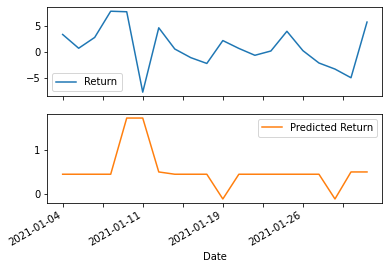

In [14]:
# Plot the first 20 predictions vs the true values
Results[:20].plot(subplots=True)

In [16]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(
    Results["Return"],
    Results["Predicted Return"])
print(f"Mean Squared Error = {mse}")

Mean Squared Error = 23.755748580633696


In [17]:
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 4.873986928648219


In [18]:
# Construct a dataframe using just the "y" training data:
in_sample_results = pd.DataFrame(y_train)

# Add a column of "in-sample" predictions to that dataframe:  
in_sample_results["In-sample Predictions"] = model.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sample_mse = mean_squared_error(in_sample_results["Return"],in_sample_results["In-sample Predictions"])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sample_rmse = np.sqrt(in_sample_mse)
print(f"In-sample Root Mean Squared Error (RMSE): {in_sample_rmse}")

In-sample Root Mean Squared Error (RMSE): 4.285282128751048


In [ ]:
# XGBoost regressor performed better than Random Forest Regressor, however, still not satisfactory predictive ability on this dataset. 

## We will evaluate classification performace to see how well this model can predict the trend.